# Performing calculation of reaction path using Reaktoro

In this tutorial, we demonstrate how to calculate a reaction path between two different chemical states in
equilibrium, which we refer to as *initial state* and *final state*.
These states can have different temperatures, pressures, and/or molar amounts of elements. If we gradually adjust
temperature, pressure, and elemental amounts in the system to bring the initial state to the final state, slowly
enough so that **every intermediate state is in equilibrium**, the system would trace a co-called *reaction path*.

Let the initial state have 1 g of calcite (CaCO<sub>3</sub>) mixed with 1 kg of water. We want to see how the
addition of
hydrochloric acid (HCl), up to 1 mmol, contributes to the dissolution of calcite. Thus, our initial and final
states for a reaction path calculation can be described as follows:

| Initial state  | Final state    |
|----------------|----------------|
| 1 kg of H2O    | 1 kg of H2O    |
| 1 g of CaCO3   | 1 g of CaCO3   |
| <p></p>        | 1 mmol of HCl  |

As usual, we start by importing the `reaktoro` package:

In [ ]:
from reaktoro import *

Note that the object `editor` from class
[ChemicalEditor](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalEditor.html) was not initialized with a given
[Database](https://reaktoro.org/cpp/classReaktoro_1_1Database.html) object. Instead, it is initialized using the
default built-in database file
[supcrt98.xml](https://github.com/reaktoro/reaktoro/blob/master/databases/supcrt/supcrt98.xml).

In [ ]:
editor = ChemicalEditor()

For the aqueous phases, we list the chemical elements composing the phase instead of the exact names of species.
Class [ChemicalEditor](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalEditor.html) searches for all species in
the database that can be formed by those elements. Only species corresponding to the phase-type are selected
(e.g., only aqueous species are searched in the current case).

In [ ]:
editor.addAqueousPhaseWithElements("H O Ca C Cl")
editor.addMineralPhase("Calcite")

system = ChemicalSystem(editor)

In the code below, two instances of the class
[EquilibriumProblem](https://reaktoro.org/cpp/classReaktoro_1_1EquilibriumProblem.html) are created:
`initial_problem` describes the initial state, and `final_problem` corresponds to the final state.

In [ ]:
initial_problem = EquilibriumProblem(system)
initial_problem.setTemperature(30.0, "celsius")
initial_problem.setPressure(1.0, "bar")
initial_problem.add("H2O", 1, "kg")
initial_problem.add("CaCO3", 1, "g")

final_problem = EquilibriumProblem(system)
final_problem.setTemperature(30.0, "celsius")
final_problem.setPressure(1.0, "bar")
final_problem.add("H2O", 1, "kg")
final_problem.add("CaCO3", 1, "g")
final_problem.add("HCl", 1, "mmol")

Two instances of the class [ChemicalState](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalState.html) are created
to store the initial and final equilibrium states calculated by the method
[equilibrate](https://reaktoro.org/cpp/namespaceReaktoro.html#af2d3b39d3e0b8f9cb5a4d9bbb06b697e).

In [ ]:
initial_state = equilibrate(initial_problem)
final_state = equilibrate(final_problem)

Once the initial and final equilibrium states have been calculated, it is now time to trace the reaction path
between them, with each intermediate state in chemical equilibrium. For this, we use the class
[EquilibriumPath](https://reaktoro.org/cpp/classReaktoro_1_1EquilibriumPath.html). Note that its initialization
requires a [ChemicalSystem](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalSystem.html) instance:

In [ ]:
path = EquilibriumPath(system)

Before calling the method
[EquilibriumPath::solve](https://reaktoro.org/cpp/classReaktoro_1_1EquilibriumPath.html#a008b74301618ed186caa95ec059eb204)
, one can configure output-file to be generated during the calculation.
To output quantities to a file or terminal during the calculation, use method
[EquilibriumPath::output](https://reaktoro.org/cpp/classReaktoro_1_1EquilibriumPath.html#ac700ac6f939acbd4a8524e1346a1e588),
which returns an instance of class [ChemicalOutput](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalOutput.html):

In [ ]:
output = path.output()
output.filename("result.txt")
output.add("elementAmount(Cl units=mmol)", "Cl [mmol]")
output.add("speciesMolality(CO2(aq) units=mmolal)", "CO2(aq) [mmol]")
output.add("speciesMolality(CO3-- units=mmolal)", "CO3-- [mmol]")
output.add("elementMolality(Ca units=mmolal)", "Ca [mmolal]")
output.add("pH")
output.add("speciesMass(Calcite units=g)")

The method [ChemicalOutput::add](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalOutput.html#af3b5a7d6b0fbbc870664d6ad100b10dd)
adds a quantity, which we want to be output to the file `result.txt`. The later filename is specified in the call of
the method [ChemicalOutput::filename](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalOutput.html#ac5cc9d0f90cfe5c6e0972a55b7f7bf5d).
Each call to [ChemicalOutput::add](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalOutput.html#af3b5a7d6b0fbbc870664d6ad100b10dd)
results in a new column of data in the output file.

> **Note**: When two arguments are provided to the method
[ChemicalOutput::add](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalOutput.html#a54b0e4fd28823c4d1d1884c32eed1cf3),
the first one is the name of the quantity to be output (e.g.,
`time`, `elementAmount(Cl)`, `ionicStrength`). The second one is a label used as the heading of the column of data
in the output file. When only one argument is provided, this single argument is both the label and the quantity name.

Finally, after output files have been configured, the equilibrium path can be calculated using:

In [ ]:
path = path.solve(initial_state, final_state)

### Plotting the results of equilibrium path calculation

The best way to visually analyze the obtained reaction path is with plots. For that, we export python plotting
package `matplotlib` and `numpy`, the fundamental package for scientific computing with Python.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

To load results from the outputfile, we use `loadtxt` function provided by the `numpy` package:

In [ ]:
filearray = np.loadtxt("result.txt", skiprows=1)
data = filearray.T
[cl_indx, co2aq_indx, co3_indx, ca_indx, ph_indx, calcite_indx] = np.arange(6)

The first plot, depicts sets the amount of element Cl in units of mmol (on the *x*-axis) and the pH of
the aqueous phase (on the *y*-axis):

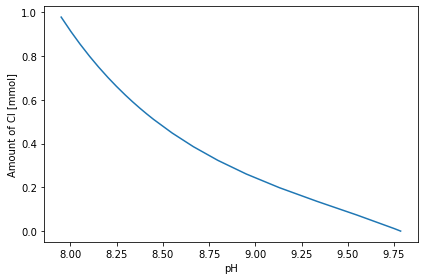

In [29]:
plt.figure()
plt.plot(data[ph_indx], data[cl_indx], label="Cl")
plt.xlabel("pH")
plt.ylabel("Amount of Cl [mmol]")
plt.tight_layout()

The second plot sets the *x*-axis to the amount of Cl from added HCl and
the *y*-axis to the molality of element Ca, i.e., the molar amount of Ca **in the aqueous
phase**, divided by the mass of solvent water H<sub>2</sub>O(l).

In [ ]:
plt.figure()
plt.plot(data[cl_indx], data[ca_indx], label="Ca")
plt.xlabel("Amount of Cl [mmol]")
plt.ylabel("Concentration of Ca [mmolal]")
plt.tight_layout()

The third plot the *x*-axis to pH, but the *y*-axis now contains two plotted quantities: the molality of species
CO<sub>2</sub>(aq) and the molality of species CO<sub>3</sub><sup>2-</sup>, both in units of mmolal (i.e., mmol/kg).

In [ ]:
plt.figure()
plt.plot(data[ph_indx], data[co2aq_indx], label="CO2(aq)")
plt.plot(data[ph_indx], data[co3_indx], label="CO3--")
plt.xlabel("pH")
plt.ylabel("Concentration [mmolal]")
plt.legend(loc='center right')
plt.tight_layout()

The fourth and last figure finally plots how the mass of calcite (or calcium carbonate) changes with the addition of
HCl in the system:

In [ ]:
plt.figure()
plt.plot(data[cl_indx], data[calcite_indx], label="Calcite")
plt.xlabel("HCl [mmol]")
plt.ylabel("Mass [g]")
plt.legend(loc='center right')
plt.tight_layout()